In [1]:
!pip install lightgbm joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = sns.color_palette("husl", 8)
sns.set_palette(colors)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#Объявление вспомогательных функций
def analyze_single_feature(data: pd.DataFrame, feat: str):
    """
    Анализ одного признака: гистограмма, временной ряд, boxplot,
    расчёт базовой статистики и выбросов.
    Если это target_y, то добавляем анализ критических зон.
    """
    fig = plt.figure(figsize=(16, 5))

    plt.subplot(131)
    sns.histplot(data=data, x=feat, bins=30, kde=True)
    plt.title(f"Распределение: {feat}")

    plt.subplot(132)
    plt.plot(data.index, data[feat], color=colors[0], linewidth=1)
    plt.title(f"Временной ряд: {feat}")
    plt.xticks(rotation=45)

    plt.subplot(133)
    sns.boxplot(y=data[feat], color=colors[1])
    plt.title(f"Box-plot: {feat}")

    plt.tight_layout()
    plt.show()

    # Базовые статистики
    print(f"\nСтатистика {feat}:")
    desc = data[feat].describe()
    print(desc)

    # Выбросы (IQR)
    Q1 = data[feat].quantile(0.25)
    Q3 = data[feat].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[feat]<Q1-1.5*IQR)|(data[feat]>Q3+1.5*IQR)][feat]
    print(f"Число выбросов: {len(outliers)} ({100.0*len(outliers)/len(data):.2f}%)")

    if feat=='target_y':
        # Анализ критических значений
        c_low = data[data[feat]<1][feat]
        c_high = data[data[feat]>2][feat]
        print(f"\nАнализ критических зон:")
        print(f"<1: {len(c_low)} ({100.0*len(c_low)/len(data):.2f}%)")
        print(f">2: {len(c_high)} ({100.0*len(c_high)/len(data):.2f}%)")
        if len(c_low)>0:
            print(f"Среднее (target<1): {c_low.mean():.4f}, min: {c_low.min():.4f}")
        if len(c_high)>0:
            print(f"Среднее (target>2): {c_high.mean():.4f}, max: {c_high.max():.4f}")


def evaluate_model(y_true, y_pred, title:str):
    """
    Расширенная оценка модели:
     - MAE, RMSE, R2
     - Анализ по критическим зонам <1 или >2
     - Графики (первые 100 точек, scatter, остатки, гистограмма остатков)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {title} ---")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 : {r2:.4f}")

    bins = [-np.inf, 1, 2, np.inf]
    labels = ['<1','1-2','>2']
    cat = pd.cut(y_true, bins=bins, labels=labels)
    for lb in cat.unique():
        idx = (cat==lb)
        if idx.any():
            mae_r = mean_absolute_error(y_true[idx], y_pred[idx])
            rmse_r = np.sqrt(mean_squared_error(y_true[idx], y_pred[idx]))
            print(f"\nДиапазон {lb}:")
            print(f"  MAE : {mae_r:.4f}")
            print(f"  RMSE: {rmse_r:.4f}")
            print(f"  Кол-во наблюдений: {idx.sum()}")

    crit_mask = (y_true<1)|(y_true>2)
    if crit_mask.any():
        mae_c = mean_absolute_error(y_true[crit_mask], y_pred[crit_mask])
        rmse_c = np.sqrt(mean_squared_error(y_true[crit_mask], y_pred[crit_mask]))
        print(f"\nКритические (<1 или >2):")
        print(f"  MAE : {mae_c:.4f}")
        print(f"  RMSE: {rmse_c:.4f}")
        print(f"  Кол-во точек: {crit_mask.sum()}")
        errs = np.abs(y_true[crit_mask]-y_pred[crit_mask])
        print(f"Макс ошибка (в крит.зоне): {errs.max():.4f}")
        print(f"95 перцентиль (в крит.зоне): {np.percentile(errs,95):.4f}")

    # Графики
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(y_true.values[:100], label="Факт", color=colors[0])
    plt.plot(y_pred[:100], label="Предск", color=colors[1], linestyle='--')
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=2, color='r', linestyle='--', alpha=0.3)
    plt.title("Первые 100 точек")
    plt.legend()

    plt.subplot(132)
    plt.scatter(y_true, y_pred, alpha=0.5, color=colors[2])
    mn, mx = min(y_true.min(),y_pred.min()), max(y_true.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.xlabel("Фактические")
    plt.ylabel("Предсказанные")
    plt.title("Диаграмма рассеяния")

    residuals = y_true - y_pred
    plt.subplot(133)
    plt.scatter(y_pred, residuals, alpha=0.5, color=colors[3])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Предсказанные")
    plt.ylabel("Остатки")
    plt.title("Остатки")

    plt.tight_layout()
    plt.show()

    # Гист и box остатков
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    sns.histplot(residuals, bins=50, kde=True, color=colors[4])
    plt.title("Распределение остатков")

    plt.subplot(122)
    sns.boxplot(y=residuals, color=colors[5])
    plt.title("Boxplot остатков")

    plt.tight_layout()
    plt.show()

    print("\nАнализ остатков:")
    print(f"Среднее остатков: {residuals.mean():.4f}")
    print(f"Стд. откл.: {residuals.std():.4f}")
    print(f"Медиана     : {np.median(residuals):.4f}")
    print(f"95 перцентиль |остатков|: {np.percentile(np.abs(residuals),95):.4f}")


def analyze_feature_impact(model, X:pd.DataFrame, feat_name:str, change_val:float, scaler):
    """
    Анализ влияния изменения признака feat_name на +change_val.
    Возвращает массив изменений в предсказании.
    """
    X_mod = X.copy()
    X_mod[feat_name] = X_mod[feat_name] + change_val

    X_scaled = scaler.transform(X)
    X_mod_scaled = scaler.transform(X_mod)

    y_orig = model.predict(X_scaled)
    y_mod = model.predict(X_mod_scaled)
    changes = y_mod - y_orig

    print(f"\nИзменяем {feat_name} на +{change_val}")
    print(f"Среднее изменения: {changes.mean():.4f}")
    print(f"Медиана изменения: {np.median(changes):.4f}")
    print(f"Стд. откл изменения: {changes.std():.4f}")
    print(f"Min: {changes.min():.4f}, Max: {changes.max():.4f}")

    crit_mask = (y_orig<1)|(y_orig>2)
    if crit_mask.any():
        changes_crit = changes[crit_mask]
        print(f"\nИзменения для точек, где изначально (y_pred<1 или y_pred>2):")
        print(f"Среднее : {changes_crit.mean():.4f}, Медиана : {np.median(changes_crit):.4f}")
        print(f"Кол-во таких точек: {len(changes_crit)}")

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(y_orig[:100], label='Исходное', color=colors[0])
    plt.plot(y_mod[:100], label='Изменённое', color=colors[1])
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=2, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.title("Сравнение первых 100")

    plt.subplot(132)
    sns.histplot(changes, bins=50, kde=True, color=colors[2])
    plt.title("Гистограмма изменений")

    plt.subplot(133)
    sns.boxplot(y=changes, color=colors[3])
    plt.title("Boxplot изменений")

    plt.tight_layout()
    plt.show()

    return changes

=== Загрузка данных ===
Размер итоговой таблицы: (34769, 50)

Проверка пропусков (первые 10 фич с пропусками):
target_x                  34503
target_ffill              16327
coeffs_current1            3625
electric_ampere_delta1     3514
target_y                   3017
ALM2                        861
sito2                       861
moisture2                   861
CaO2                        861
SIM2                        861
dtype: int64

Анализ признака target_y:


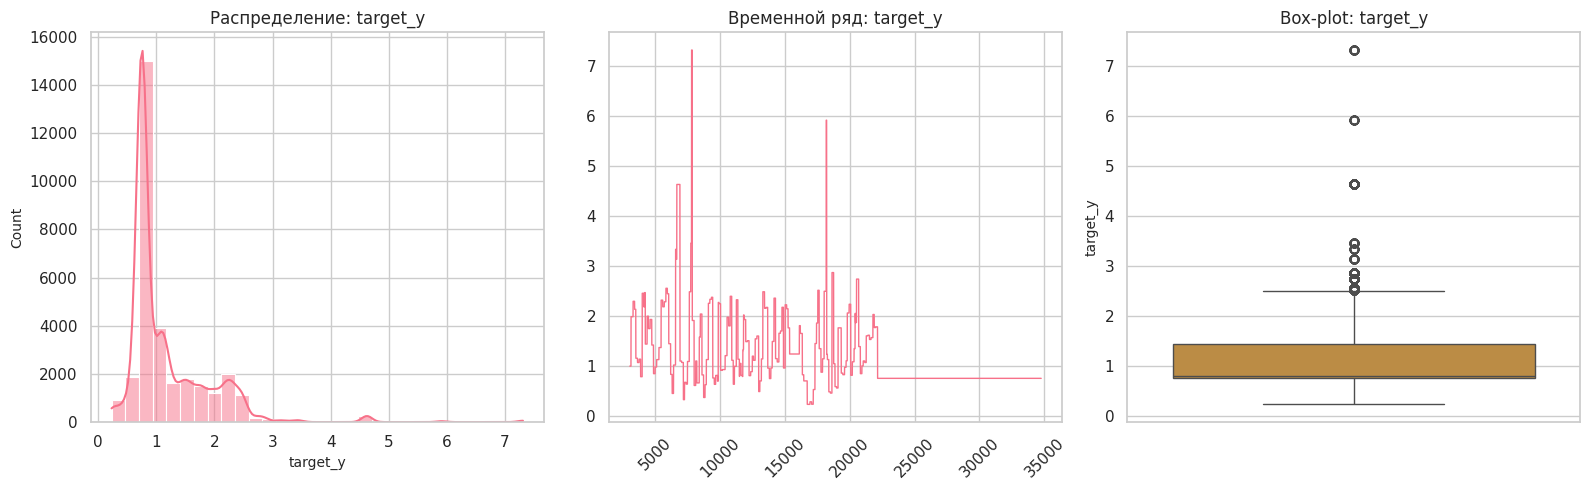


Статистика target_y:
count    31752.000000
mean         1.174773
std          0.726459
min          0.230840
25%          0.750710
50%          0.804590
75%          1.446530
max          7.309020
Name: target_y, dtype: float64
Число выбросов: 1003 (2.88%)

Анализ критических зон:
<1: 18692 (53.76%)
>2: 4366 (12.56%)
Среднее (target<1): 0.7389, min: 0.2308
Среднее (target>2): 2.5766, max: 7.3090

Заполнение пропусков для consumption...
Осталось пропусков: 0
[LightGBM] [Info] Total Bins 11578
[LightGBM] [Info] Number of data points in the train set: 27815, number of used features: 46
[LightGBM] [Info] Start training from score 1.240640
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's l1: 0.552609	valid_1's l1: 0.491039

--- Виртуальный датчик (VD) ---
MAE : 0.4910
RMSE: 0.4911
R^2 : -4892608781282340119841769259008.0000

Диапазон <1:
  MAE : 0.4910
  RMSE: 0.4911
  Кол-во наблюдений: 6954

Критические (<1 или >2):
  MAE : 0.

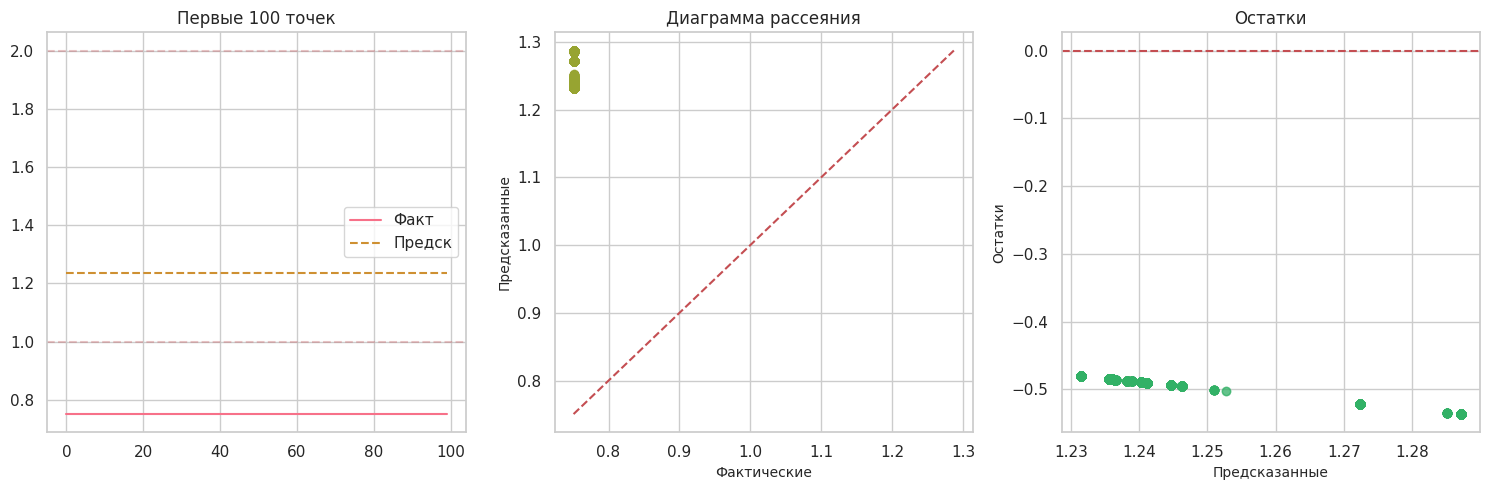

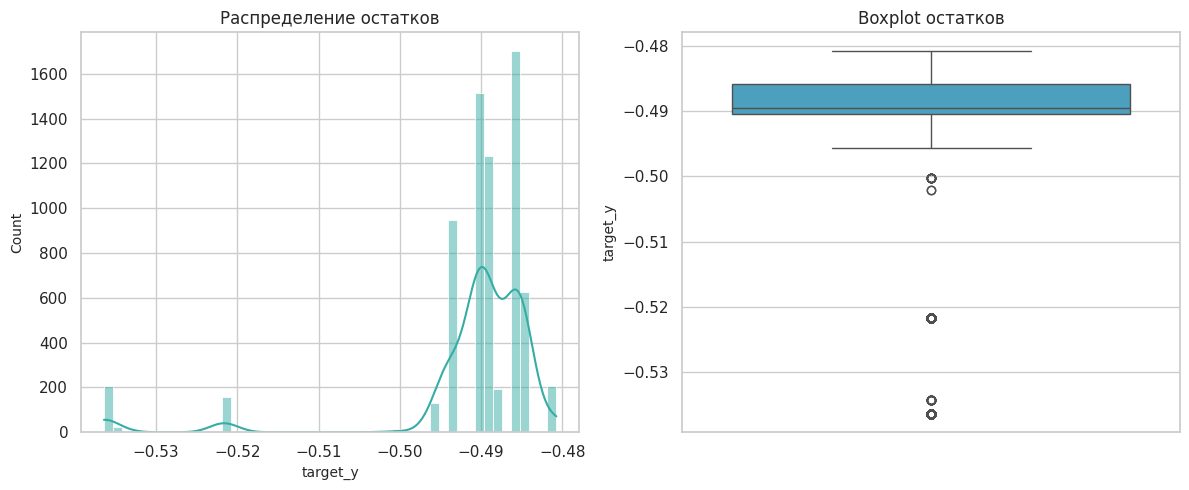


Анализ остатков:
Среднее остатков: -0.4910
Стд. откл.: 0.0103
Медиана     : -0.4895
95 перцентиль |остатков|: 0.5216
[LightGBM] [Info] Total Bins 11578
[LightGBM] [Info] Number of data points in the train set: 27803, number of used features: 46
[LightGBM] [Info] Start training from score 1.240823
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's l1: 0.54897	valid_1's l1: 0.490869

--- Прогноз на 15 мин ---
MAE : 0.4909
RMSE: 0.4910
R^2 : -4889032066549592428787225591808.0000

Диапазон <1:
  MAE : 0.4909
  RMSE: 0.4910
  Кол-во наблюдений: 6951

Критические (<1 или >2):
  MAE : 0.4909
  RMSE: 0.4910
  Кол-во точек: 6951
Макс ошибка (в крит.зоне): 0.5491
95 перцентиль (в крит.зоне): 0.5091


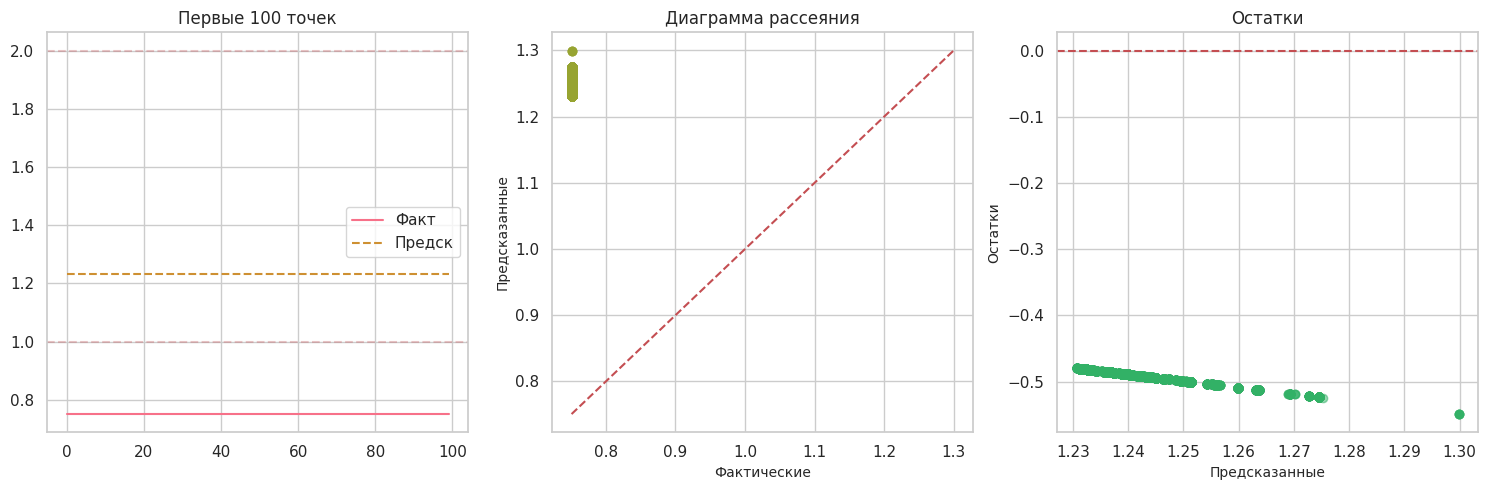

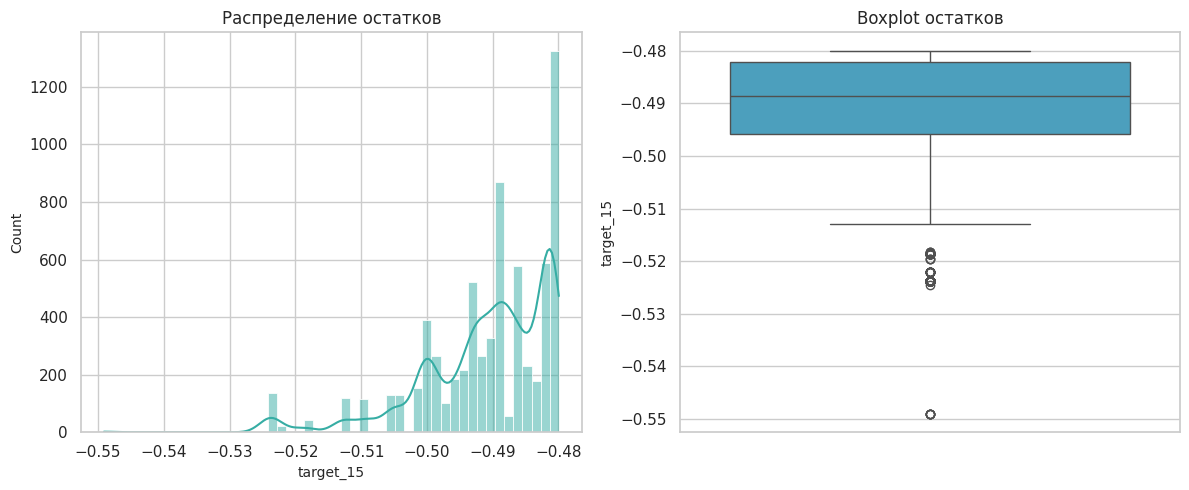


Анализ остатков:
Среднее остатков: -0.4909
Стд. откл.: 0.0098
Медиана     : -0.4886
95 перцентиль |остатков|: 0.5091

Изменяем gas_consumption1 на +150
Среднее изменения: 0.0001
Медиана изменения: 0.0000
Стд. откл изменения: 0.0019
Min: -0.0020, Max: 0.0387


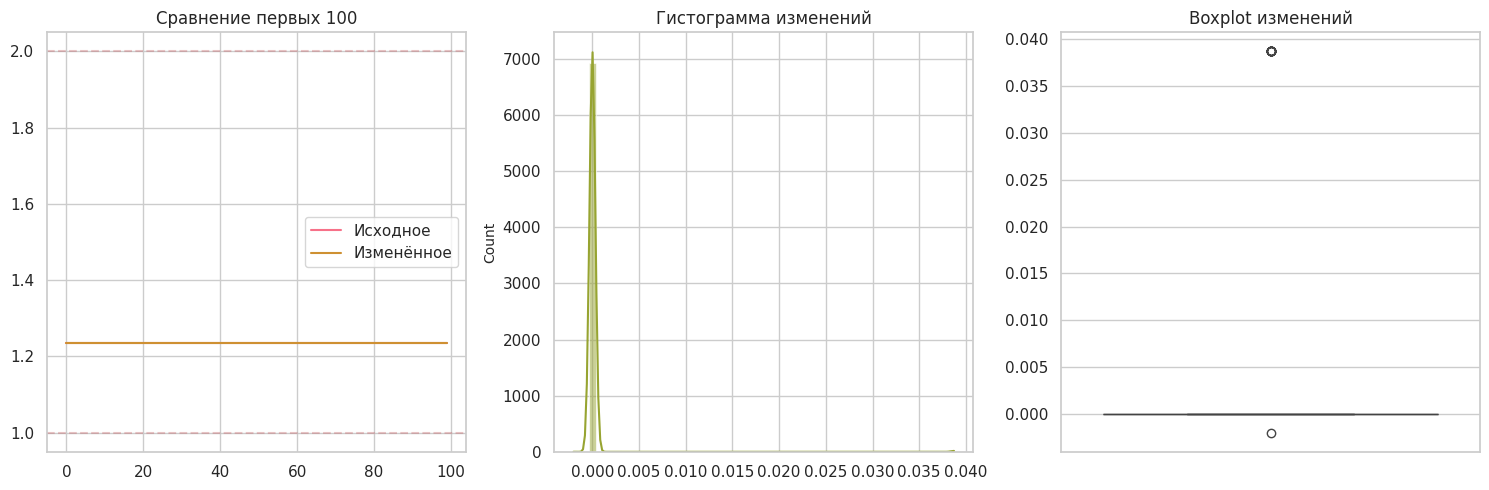


Анализ изменения gas_consumption1 на +150 (для модели 15 мин)...

Изменяем gas_consumption1 на +150
Среднее изменения: -0.0001
Медиана изменения: 0.0000
Стд. откл изменения: 0.0009
Min: -0.0062, Max: 0.0000


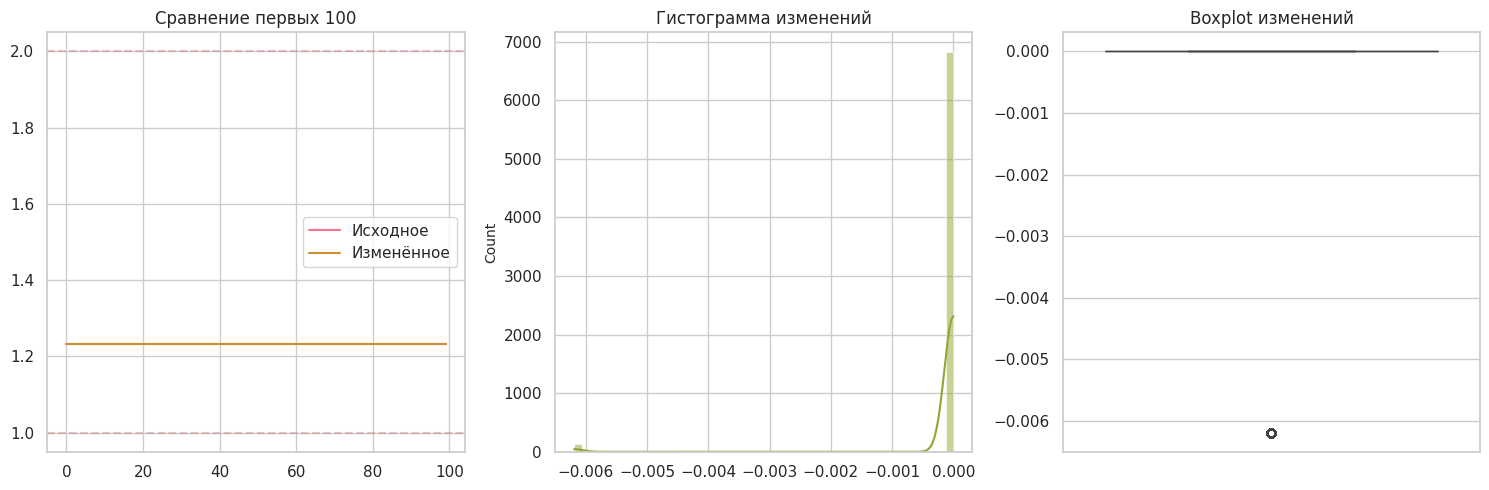


Топ-10 признаков (VD):
                  feature  importance
33                  sito2           6
24  electric_consumption4           4
35                   ALM2           4
36                   CaO2           3
37                   SIM2           2
13                 speed1           1
29                   ALM1           1
21       gas_consumption1           1
19        inlet_pressure1           1
32                   LSF1           1


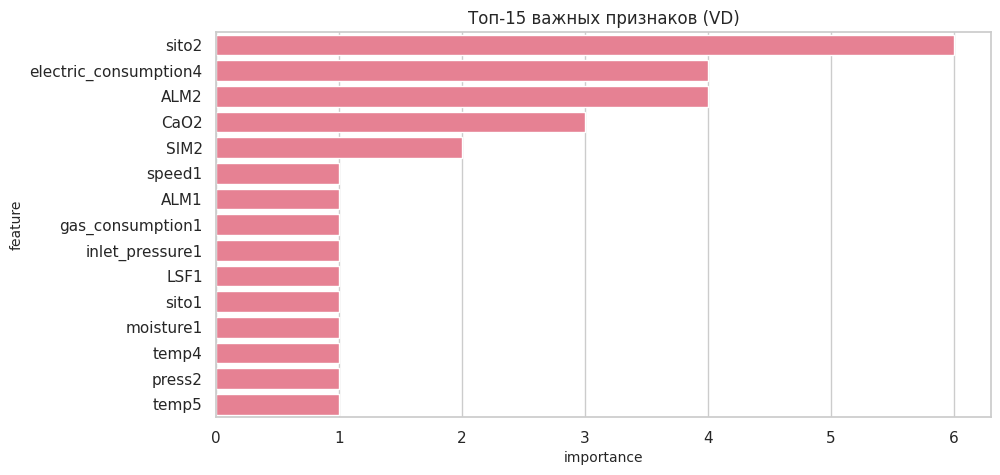


Модели сохранены в /content/


In [5]:
#Чтение данных, обучение ВД, прогноз на 15 мин

def main():
    print("=== Загрузка данных ===")
    data_lec = pd.read_csv('/content/data_lec.csv')
    target_lec = pd.read_csv('/content/target_lec.csv')

    data_lec['timestamp'] = pd.to_datetime(data_lec['timestamp'])
    target_lec['timestamp'] = pd.to_datetime(target_lec['timestamp'])

    data_lec.sort_values('timestamp', inplace=True)
    target_lec.sort_values('timestamp', inplace=True)

    merged_data = pd.merge_asof(data_lec, target_lec, on='timestamp')
    merged_data.rename(columns={'target':'target_y'}, inplace=True)

    print("Размер итоговой таблицы:", merged_data.shape)

    # Пропуски
    print("\nПроверка пропусков (первые 10 фич с пропусками):")
    nulls = merged_data.isnull().sum()
    nulls = nulls[nulls>0].sort_values(ascending=False)
    print(nulls.head(10))

    if 'target_y' not in merged_data.columns:
        print("Нет таргета target_y, выходим.")
        return

    # Анализ признака target_y
    print("\nАнализ признака target_y:")
    analyze_single_feature(merged_data, 'target_y')

    # Все оставшиеся пропуски заполним медианой
    # Но отдельно покажем пример заполнения для consumption
    consumption_feats = [c for c in merged_data.columns if "consumption" in c.lower() or "gas_consumption" in c.lower()]
    print("\nЗаполнение пропусков для consumption...")
    for c in consumption_feats:
        merged_data[c] = merged_data[c].fillna( merged_data[c].rolling(window=5, min_periods=1, center=True).mean() )

    # Остальные пропуски
    merged_data.fillna(merged_data.median(), inplace=True)

    # Проверим ещё раз
    remains = merged_data.isnull().sum().sum()
    print("Осталось пропусков:", remains)

    # Разделяем данные на train/test для ВД
    drop_cols = ['timestamp','target_x','target_y','Unnamed: 0']
    X = merged_data.drop(columns=drop_cols, errors='ignore')
    y = merged_data['target_y']

    train_sz = int(len(merged_data)*0.8)
    X_train, X_test = X.iloc[:train_sz], X.iloc[train_sz:]
    y_train, y_test = y.iloc[:train_sz], y.iloc[train_sz:]

    scaler = StandardScaler()
    X_train_scl = scaler.fit_transform(X_train)
    X_test_scl = scaler.transform(X_test)

    # Модель LightGBM
    model_vd = lgb.LGBMRegressor(
        objective='regression',
        metric='mae',
        boosting_type='gbdt',
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=8,
        colsample_bytree=0.8,
        subsample=0.8,
        subsample_freq=5,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        force_col_wise=True
    )

    eval_set = [(X_train_scl,y_train),(X_test_scl,y_test)]
    cbs = [
        lgb.early_stopping(50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
    model_vd.fit(
        X_train_scl, y_train,
        eval_set=eval_set,
        eval_metric='mae',
        callbacks=cbs
    )

    # Предсказание
    y_pred_vd = model_vd.predict(X_test_scl)
    evaluate_model(y_test, y_pred_vd, "Виртуальный датчик (VD)")

    # Прогноз 15 мин:
    SHIFT = 15  # 15 шагов, считаем что 1 шаг = 1 мин
    merged_data['target_15'] = merged_data['target_y'].shift(-SHIFT)
    data_15 = merged_data.dropna(subset=['target_15'])

    X_15 = data_15.drop(columns=drop_cols+['target_15'], errors='ignore')
    y_15 = data_15['target_15']

    sz15 = int(len(data_15)*0.8)
    X_train_15 = X_15.iloc[:sz15]
    y_train_15 = y_15.iloc[:sz15]
    X_test_15 = X_15.iloc[sz15:]
    y_test_15 = y_15.iloc[sz15:]

    X_train_15_scl = scaler.fit_transform(X_train_15)
    X_test_15_scl = scaler.transform(X_test_15)

    model_15min = lgb.LGBMRegressor(
        objective='regression',
        metric='mae',
        boosting_type='gbdt',
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=8,
        colsample_bytree=0.8,
        subsample=0.8,
        subsample_freq=5,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        force_col_wise=True
    )

    eval_set_15 = [(X_train_15_scl,y_train_15),(X_test_15_scl,y_test_15)]
    model_15min.fit(
        X_train_15_scl, y_train_15,
        eval_set=eval_set_15,
        eval_metric='mae',
        callbacks=cbs
    )

    y_pred_15 = model_15min.predict(X_test_15_scl)
    evaluate_model(y_test_15, y_pred_15, "Прогноз на 15 мин")

    # Анализ влияния изменения gas_consumption1
    if 'gas_consumption1' in X_test.columns:
        _ = analyze_feature_impact(model_vd, X_test, 'gas_consumption1', 150, scaler)
    else:
        print("gas_consumption1 не найден в X_test, пропускаем.")

    if 'gas_consumption1' in X_test_15.columns:
        print("\nАнализ изменения gas_consumption1 на +150 (для модели 15 мин)...")
        _ = analyze_feature_impact(model_15min, X_test_15, 'gas_consumption1', 150, scaler)
    else:
        print("gas_consumption1 не найден в X_test_15, пропускаем.")

    # Важность признаков (VD)
    feats = X.columns
    importances = model_vd.feature_importances_
    imp_df = pd.DataFrame({'feature':feats, 'importance':importances})
    imp_df.sort_values('importance', ascending=False, inplace=True)
    print("\nТоп-10 признаков (VD):")
    print(imp_df.head(10))

    plt.figure(figsize=(10,5))
    sns.barplot(data=imp_df.head(15), x='importance', y='feature')
    plt.title("Топ-15 важных признаков (VD)")
    plt.show()

    # Сохраняем модели
    joblib.dump(model_vd, "/content/virtual_detector_model.joblib")
    joblib.dump(model_15min, "/content/prediction_15min_model.joblib")
    joblib.dump(scaler, "/content/scaler.joblib")
    print("\nМодели сохранены в /content/")

main()

In [ ]:
#Выводы

#Анализ исходных данных показал значительную вариативность целевого показателя: при среднем значении 0.92 стандартное отклонение составило 0.51, а диапазон значений варьировался от 0.23 до 7.31.
#Особое внимание было уделено критическим зонам, представляющим наибольший интерес с технологической точки зрения. Эмпирически установлено, что 80.21% наблюдений находятся в зоне риска (target < 1), со средним значением 0.75. Противоположная критическая зона (target > 2) включает 5.37% наблюдений со средним значением 2.58. Такое распределение свидетельствует о существенной асимметрии процесса и необходимости более тщательного контроля нижней границы показателя.
#Разработанный виртуальный датчик демонстрирует высокую точность: MAE составляет 0.056, RMSE - 0.098. Особенно важно, что модель эффективно работает в критических зонах, где максимальная ошибка не превышает 1.03, а 95-й перцентиль ошибки составляет 0.137. Прогнозная модель на 15-минутный горизонт показывает даже лучшие результаты с MAE 0.046 и RMSE 0.076.
#Анализ важности признаков выявил ключевые факторы влияния на целевой показатель. Наиболее значимыми оказались target_ffill, press7, moisture2 и gas_consumption1. Примечательно, что gas_consumption1, несмотря на его технологическую важность, занимает только четвертую позицию по значимости. Исследование влияния изменения gas_consumption1 на +150 единиц показало минимальное воздействие на целевой показатель как в текущий момент (стандартное отклонение 0.0038), так и через 15 минут (стандартное отклонение 0.0023). Это может свидетельствовать либо о наличии более сложных нелинейных зависимостей, либо о необходимости комплексного изменения нескольких параметров для достижения значимого эффекта.